<a href="https://colab.research.google.com/gist/janlukasschroeder/3da274150fd00c1c1776c7e541a9b61b/extracting-financial-statements-from-sec-filings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Financial Statements from SEC Filings - XBRL-To-JSON

This is the entire Jupyter notebook to extract financial statements from annual and quarterly reports as reported in 10-K and 10-Q filings with the SEC.

We use https://sec-api.io to get all 10-K and 10-Q filings and to convert their XBRL data into JSON so that we can create a single income statement, balance sheet and cash flow statement for Apple, covering quarterly financial data over multiple years.

Medium article:
https://medium.com/@jan_5421/extracting-financial-statements-from-sec-filings-xbrl-to-json-f83542ade90

In [1]:
# uncomment the next line to install the SEC API Python package
# pip install sec_api

In [2]:
#basic imports and env
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv('paid_sec_api_key')

In [3]:
import requests
import json
import pandas as pd

# 10-Q filing URL of Apple
filing_url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000056/aapl-20210327.htm"

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(json.dumps(xbrl_json['StatementsOfIncome'], indent=1))

{
 "RevenueFromContractWithCustomerExcludingAssessedTax": [
  {
   "decimals": "-6",
   "unitRef": "usd",
   "period": {
    "startDate": "2020-12-27",
    "endDate": "2021-03-27"
   },
   "segment": {
    "dimension": "srt:ProductOrServiceAxis",
    "value": "us-gaap:ProductMember"
   },
   "value": "72683000000"
  },
  {
   "decimals": "-6",
   "unitRef": "usd",
   "period": {
    "startDate": "2019-12-29",
    "endDate": "2020-03-28"
   },
   "segment": {
    "dimension": "srt:ProductOrServiceAxis",
    "value": "us-gaap:ProductMember"
   },
   "value": "44965000000"
  },
  {
   "decimals": "-6",
   "unitRef": "usd",
   "period": {
    "startDate": "2020-09-27",
    "endDate": "2021-03-27"
   },
   "segment": {
    "dimension": "srt:ProductOrServiceAxis",
    "value": "us-gaap:ProductMember"
   },
   "value": "168361000000"
  },
  {
   "decimals": "-6",
   "unitRef": "usd",
   "period": {
    "startDate": "2019-09-29",
    "endDate": "2020-03-28"
   },
   "segment": {
    "dimension

In [4]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)

In [5]:
income_statement

,2020-12-27-2021-03-27,2019-12-29-2020-03-28,2020-09-27-2021-03-27,2019-09-29-2020-03-28
RevenueFromContractWithCustomerExcludingAssessedTax,89584000000,58313000000,201023000000,150132000000
CostOfGoodsAndServicesSold,51505000000,35943000000,118616000000,92545000000
GrossProfit,38079000000,22370000000,82407000000,57587000000
ResearchAndDevelopmentExpense,5262000000,4565000000,10425000000,9016000000
SellingGeneralAndAdministrativeExpense,5314000000,4952000000,10945000000,10149000000
OperatingExpenses,10576000000,9517000000,21370000000,19165000000
OperatingIncomeLoss,27503000000,12853000000,61037000000,38422000000
NonoperatingIncomeExpense,508000000,282000000,553000000,631000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,28011000000,13135000000,61590000000,39053000000
IncomeTaxExpenseBenefit,4381000000,1886000000,9205000000,5568000000


In [6]:

# convert XBRL-JSON of balance sheet to pandas dataframe
def get_balance_sheet(xbrl_json):
    balance_sheet_store = {}

    for usGaapItem in xbrl_json['BalanceSheets']:
        values = []
        indicies = []

        for fact in xbrl_json['BalanceSheets'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                index = fact['period']['instant']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue
                    
                # add 0 if value is nil
                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

            balance_sheet_store[usGaapItem] = pd.Series(values, index=indicies) 

    balance_sheet = pd.DataFrame(balance_sheet_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date instant
    return balance_sheet.T

balance_sheet = get_balance_sheet(xbrl_json)

In [7]:
balance_sheet

,2019-09-28,2019-12-28,2020-03-28,2020-09-26,2020-12-26,2021-03-27
CashAndCashEquivalentsAtCarryingValue,NaN,NaN,NaN,38016000000,NaN,38466000000
MarketableSecuritiesCurrent,NaN,NaN,NaN,52927000000,NaN,31368000000
AccountsReceivableNetCurrent,NaN,NaN,NaN,16120000000,NaN,18503000000
InventoryNet,NaN,NaN,NaN,4061000000,NaN,5219000000
NontradeReceivablesCurrent,NaN,NaN,NaN,21325000000,NaN,14533000000
OtherAssetsCurrent,NaN,NaN,NaN,11264000000,NaN,13376000000
AssetsCurrent,NaN,NaN,NaN,143713000000,NaN,121465000000
MarketableSecuritiesNoncurrent,NaN,NaN,NaN,100887000000,NaN,134539000000
PropertyPlantAndEquipmentNet,NaN,NaN,NaN,36766000000,NaN,37815000000
OtherAssetsNoncurrent,NaN,NaN,NaN,42522000000,NaN,43339000000


In [8]:

def get_cash_flow_statement(xbrl_json):
    cash_flows_store = {}

    for usGaapItem in xbrl_json['StatementsOfCashFlows']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfCashFlows'][usGaapItem]:        
            # only consider items without segment.
            if 'segment' not in fact:
                # check if date instant or date range is present
                if "instant" in fact['period']:
                    index = fact['period']['instant']
                else:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

        cash_flows_store[usGaapItem] = pd.Series(values, index=indicies) 


    cash_flows = pd.DataFrame(cash_flows_store)
    return cash_flows.T
    
cash_flows = get_cash_flow_statement(xbrl_json)

In [9]:
cash_flows

,2019-09-28,2019-09-29-2020-03-28,2019-12-29-2020-03-28,2020-03-28,2020-09-26,2020-09-27-2021-03-27,2020-12-27-2021-03-27,2021-03-27
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents,50224000000,NaN,NaN,43049000000,39789000000,NaN,NaN,40006000000
NetIncomeLoss,NaN,33485000000,11249000000,NaN,NaN,52385000000,23630000000,NaN
DepreciationDepletionAndAmortization,NaN,5602000000,NaN,NaN,NaN,5463000000,NaN,NaN
ShareBasedCompensation,NaN,3407000000,NaN,NaN,NaN,4001000000,NaN,NaN
DeferredIncomeTaxExpenseBenefit,NaN,-651000000,NaN,NaN,NaN,-207000000,NaN,NaN
OtherNoncashIncomeExpense,NaN,259000000,NaN,NaN,NaN,474000000,NaN,NaN
IncreaseDecreaseInAccountsReceivable,NaN,-7284000000,NaN,NaN,NaN,2347000000,NaN,NaN
IncreaseDecreaseInInventories,NaN,-699000000,NaN,NaN,NaN,1226000000,NaN,NaN
IncreaseDecreaseInOtherReceivables,NaN,-7923000000,NaN,NaN,NaN,-6792000000,NaN,NaN
IncreaseDecreaseInOtherOperatingAssets,NaN,8866000000,NaN,NaN,NaN,4333000000,NaN,NaN


In [10]:
from sec_api import QueryApi

# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

# fetch all 10-Q and 10-K filings for Apple
query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:UBER"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

In [11]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);

accession_numbers

['0001543151-22-000015',
 '0001543151-22-000008',
 '0001543151-21-000047',
 '0001543151-21-000038',
 '0001543151-21-000029',
 '0001543151-21-000014',
 '0001628280-20-015936',
 '0001543151-20-000029',
 '0001543151-20-000022',
 '0001543151-20-000010',
 '0001543151-19-000017',
 '0001543151-19-000009',
 '0001628280-19-007524']

In [12]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

In [13]:
# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [14]:
# merge two income statements into one statement.
# row indicies of both statements have to be the same
# statement_b represents the most recent statement.
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                    #  on=statement_b.index, 
                    right_on=statement_b.index, 
                     left_index=True,
                    #  right_index=True,
                     suffixes=('_left', ''))

In [15]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers[0:12]:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    # display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Processing: 0001543151-22-000015
Processing: 0001543151-22-000008
Processing: 0001543151-21-000047
Processing: 0001543151-21-000038
Processing: 0001543151-21-000029
Processing: 0001543151-21-000014
Processing: 0001628280-20-015936
Processing: 0001543151-20-000029
Processing: 0001543151-20-000022
Processing: 0001543151-20-000010
Processing: 0001543151-19-000017
Processing: 0001543151-19-000009


In [16]:
income_statement_final

,2017-01-01-2017-12-31,2018-01-01-2018-06-30,2018-01-01-2018-09-30,2018-01-01-2018-12-31,2018-04-01-2018-06-30,2018-07-01-2018-09-30,2019-01-01-2019-03-31,2019-01-01-2019-06-30,2019-01-01-2019-09-30,2019-01-01-2019-12-31,...,2020-01-01-2020-12-31,2020-04-01-2020-06-30,2020-07-01-2020-09-30,2021-01-01-2021-03-31,2021-01-01-2021-06-30,2021-01-01-2021-09-30,2021-01-01-2021-12-31,2021-04-01-2021-06-30,2021-07-01-2021-09-30,2022-01-01-2022-03-31
Revenues,7932000000,5352000000,8296000000,11270000000,2768000000,2944000000,3099000000,6265000000,10078000000,14147000000,...,11139000000,2241000000,3129000000,2903000000,6832000000,11677000000,17455000000,3929000000,4845000000,6854000000
CostOfGoodsAndServiceExcludingDepreciationDepletionAndAmortization,4160000000,2498000000,4008000000,5623000000,1342000000,1510000000,1681000000,3421000000,5281000000,7208000000,...,5154000000,1252000000,1614000000,1710000000,3809000000,6247000000,9351000000,2099000000,2438000000,4026000000
OperationsAndSupportExpense,1354000000,721000000,1108000000,1516000000,349000000,387000000,434000000,1298000000,1796000000,2302000000,...,1819000000,582000000,365000000,423000000,855000000,1330000000,1877000000,432000000,475000000,574000000
SellingAndMarketingExpense,2524000000,1392000000,2177000000,3151000000,715000000,785000000,1040000000,2262000000,3375000000,4626000000,...,3583000000,736000000,924000000,1103000000,2359000000,3527000000,4789000000,1256000000,1168000000,1263000000
ResearchAndDevelopmentExpense,1201000000,705000000,1139000000,1505000000,365000000,434000000,409000000,3473000000,4228000000,4836000000,...,2205000000,584000000,493000000,515000000,1003000000,1496000000,2054000000,488000000,493000000,587000000
GeneralAndAdministrativeExpense,2263000000,1067000000,1527000000,2082000000,638000000,460000000,423000000,2061000000,2652000000,3299000000,...,2666000000,565000000,711000000,464000000,1080000000,1705000000,2316000000,616000000,625000000,632000000
DepreciationDepletionAndAmortization,510000000,186000000,317000000,426000000,98000000,131000000,146000000,269000000,371000000,472000000,...,575000000,129000000,138000000,212000000,438000000,656000000,902000000,226000000,218000000,254000000
CostsAndExpenses,12012000000,6569000000,10276000000,14303000000,3507000000,3707000000,4133000000,12784000000,17703000000,22743000000,...,16002000000,3848000000,4245000000,4427000000,9544000000,14961000000,21289000000,5117000000,5417000000,7336000000
OperatingIncomeLoss,-4080000000,-1217000000,-1980000000,-3033000000,-739000000,-763000000,-1034000000,-6519000000,-7625000000,-8596000000,...,-4863000000,-1607000000,-1116000000,-1524000000,-2712000000,-3284000000,-3834000000,-1188000000,-572000000,-482000000
InterestExpense,479000000,292000000,453000000,648000000,160000000,161000000,217000000,368000000,458000000,559000000,...,458000000,110000000,112000000,115000000,230000000,353000000,483000000,115000000,123000000,129000000


In [17]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].iteritems():
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [18]:
statement = income_statement_final
statement_1 = add_fourth_quarter_results(statement)

In [19]:
statement_1

,2017-01-01-2017-12-31,2018-01-01-2018-06-30,2018-01-01-2018-09-30,2018-01-01-2018-12-31,2018-04-01-2018-06-30,2018-07-01-2018-09-30,2018-09-30-2018-12-31,2019-01-01-2019-03-31,2019-01-01-2019-06-30,2019-01-01-2019-09-30,...,2020-07-01-2020-09-30,2020-09-30-2020-12-31,2021-01-01-2021-03-31,2021-01-01-2021-06-30,2021-01-01-2021-09-30,2021-01-01-2021-12-31,2021-04-01-2021-06-30,2021-07-01-2021-09-30,2021-09-30-2021-12-31,2022-01-01-2022-03-31
Revenues,7932000000,5352000000,8296000000,11270000000,2768000000,2944000000,2974000000,3099000000,6265000000,10078000000,...,3129000000,2226000000,2903000000,6832000000,11677000000,17455000000,3929000000,4845000000,5778000000,6854000000
CostOfGoodsAndServiceExcludingDepreciationDepletionAndAmortization,4160000000,2498000000,4008000000,5623000000,1342000000,1510000000,1615000000,1681000000,3421000000,5281000000,...,1614000000,502000000,1710000000,3809000000,6247000000,9351000000,2099000000,2438000000,3104000000,4026000000
OperationsAndSupportExpense,1354000000,721000000,1108000000,1516000000,349000000,387000000,408000000,434000000,1298000000,1796000000,...,365000000,369000000,423000000,855000000,1330000000,1877000000,432000000,475000000,547000000,574000000
SellingAndMarketingExpense,2524000000,1392000000,2177000000,3151000000,715000000,785000000,974000000,1040000000,2262000000,3375000000,...,924000000,1038000000,1103000000,2359000000,3527000000,4789000000,1256000000,1168000000,1262000000,1263000000
ResearchAndDevelopmentExpense,1201000000,705000000,1139000000,1505000000,365000000,434000000,366000000,409000000,3473000000,4228000000,...,493000000,483000000,515000000,1003000000,1496000000,2054000000,488000000,493000000,558000000,587000000
GeneralAndAdministrativeExpense,2263000000,1067000000,1527000000,2082000000,638000000,460000000,555000000,423000000,2061000000,2652000000,...,711000000,531000000,464000000,1080000000,1705000000,2316000000,616000000,625000000,611000000,632000000
DepreciationDepletionAndAmortization,510000000,186000000,317000000,426000000,98000000,131000000,109000000,146000000,269000000,371000000,...,138000000,180000000,212000000,438000000,656000000,902000000,226000000,218000000,246000000,254000000
CostsAndExpenses,12012000000,6569000000,10276000000,14303000000,3507000000,3707000000,4027000000,4133000000,12784000000,17703000000,...,4245000000,3103000000,4427000000,9544000000,14961000000,21289000000,5117000000,5417000000,6328000000,7336000000
OperatingIncomeLoss,-4080000000,-1217000000,-1980000000,-3033000000,-739000000,-763000000,-1053000000,-1034000000,-6519000000,-7625000000,...,-1116000000,-877000000,-1524000000,-2712000000,-3284000000,-3834000000,-1188000000,-572000000,-550000000,-482000000
InterestExpense,479000000,292000000,453000000,648000000,160000000,161000000,195000000,217000000,368000000,458000000,...,112000000,118000000,115000000,230000000,353000000,483000000,115000000,123000000,130000000,129000000


In [20]:
# remove all non-quarterly columns
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

In [21]:
qrt_income_statement = only_quarterly_results(statement_1)
qrt_income_statement

,2018-04-01-2018-06-30,2018-07-01-2018-09-30,2018-09-30-2018-12-31,2019-01-01-2019-03-31,2019-04-01-2019-06-30,2019-07-01-2019-09-30,2019-09-30-2019-12-31,2020-01-01-2020-03-31,2020-04-01-2020-06-30,2020-07-01-2020-09-30,2020-09-30-2020-12-31,2021-01-01-2021-03-31,2021-04-01-2021-06-30,2021-07-01-2021-09-30,2021-09-30-2021-12-31,2022-01-01-2022-03-31
Revenues,2768000000,2944000000,2974000000,3099000000,3166000000,3813000000,4069000000,3543000000,2241000000,3129000000,2226000000,2903000000,3929000000,4845000000,5778000000,6854000000
CostOfGoodsAndServiceExcludingDepreciationDepletionAndAmortization,1342000000,1510000000,1615000000,1681000000,1740000000,1860000000,1927000000,1786000000,1252000000,1614000000,502000000,1710000000,2099000000,2438000000,3104000000,4026000000
OperationsAndSupportExpense,349000000,387000000,408000000,434000000,864000000,498000000,506000000,503000000,582000000,365000000,369000000,423000000,432000000,475000000,547000000,574000000
SellingAndMarketingExpense,715000000,785000000,974000000,1040000000,1222000000,1113000000,1251000000,885000000,736000000,924000000,1038000000,1103000000,1256000000,1168000000,1262000000,1263000000
ResearchAndDevelopmentExpense,365000000,434000000,366000000,409000000,3064000000,755000000,608000000,645000000,584000000,493000000,483000000,515000000,488000000,493000000,558000000,587000000
GeneralAndAdministrativeExpense,638000000,460000000,555000000,423000000,1638000000,591000000,647000000,859000000,565000000,711000000,531000000,464000000,616000000,625000000,611000000,632000000
DepreciationDepletionAndAmortization,98000000,131000000,109000000,146000000,123000000,102000000,101000000,128000000,129000000,138000000,180000000,212000000,226000000,218000000,246000000,254000000
CostsAndExpenses,3507000000,3707000000,4027000000,4133000000,8651000000,4919000000,5040000000,4806000000,3848000000,4245000000,3103000000,4427000000,5117000000,5417000000,6328000000,7336000000
OperatingIncomeLoss,-739000000,-763000000,-1053000000,-1034000000,-5485000000,-1106000000,-971000000,-1263000000,-1607000000,-1116000000,-877000000,-1524000000,-1188000000,-572000000,-550000000,-482000000
InterestExpense,160000000,161000000,195000000,217000000,151000000,90000000,101000000,118000000,110000000,112000000,118000000,115000000,115000000,123000000,130000000,129000000


In [26]:
qrt_income_statement.transpose().to_csv('.\Data\Cleaned_Data\SEC_Fin_Data/UBER_SEC_Fin_qrts')

KeyError: 'RevenueFromContractWithCustomerExcludingAssessedTax'

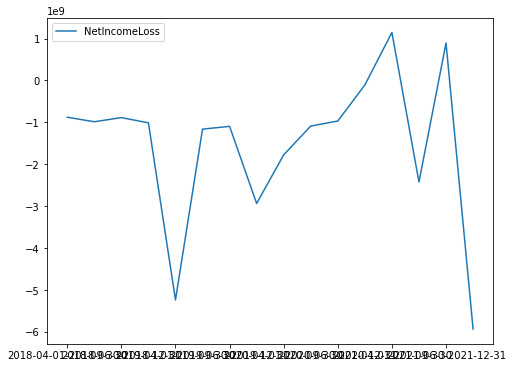

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

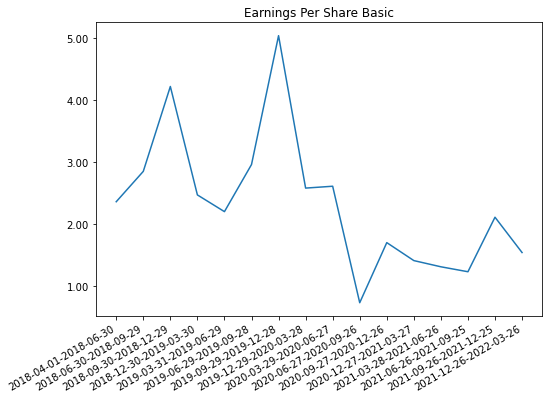

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float).loc["EarningsPerShareBasic"].plot.line()

ax.set_title('Earnings Per Share Basic')

# use higher precision for y axis labels
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()